In [1]:
# Load my_utils.ipynb in Notebook
from ipynb.fs.full.my_utils import *

Opening connection to database
Add pythagore() function to SQLite engine
Fraction of the dataset used to train models: 10.00%
my_utils library loaded :-)



It's now time to load the *NYC Taxi Travel* Dataset into a Pandas dataframe.
We load data using *load_csv* function from [my_utils](my_utils.ipynb) library.


In [2]:
# Load dataset with function from my_utils library
nyc_travel = load_csv('travel')

In [3]:
# Display first 5 lines
nyc_travel.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
# Display informations
nyc_travel.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 364660
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 133.5+ MB


Ok, this dataset is as claimed in the description, seems to have no missing values. That's good.
It is made of around 1'500'000 lines with three columns made of int64 values, four columns of float64 values and the rest is made of strings.

In [5]:
# Verify that we do not have missing values
nyc_travel.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

# Dataset cleaning process

As everything might not be useable to build my model, let's make some cleanup and reformat this dataset.

## id

The *id* column should be dropped from the dataset. It contains a unique id of the trip recorded, completly useless to train models.

In [6]:
nyc_travel.drop('id', axis=1, inplace=True)

## vendor_id

This column identifies the *vendor* of the trip but, looking at it's content, we can see that the number of different vendors is two, and the number of trips seems to be equally distributed.


In [7]:
# Get the number of unique values
print('Number of unique values within the whole dataset: {}'.format(nyc_travel['vendor_id'].nunique()))

Number of unique values within the whole dataset: 2


According to this, dropping this column seems to be an evidence.

In [8]:
nyc_travel.drop('vendor_id', axis=1, inplace=True)

## store_and_fwd_flag

The name of this column helps to determine that it's a flag, a categorical column, which contains 'Y' and 'N' values.

Let replace Y values with a 1 and N values with 0 to be able to use this feature when training our model.

In [9]:
# Confirm we have two values only in this column
nyc_travel['store_and_fwd_flag'].unique()

array(['N', 'Y'], dtype=object)

In [10]:
# Use pd.replace to create a categorical column
nyc_travel['store_and_fwd_flag']=nyc_travel['store_and_fwd_flag'].replace({'Y': 1, 'N': 0})


## trip_duration

Looking deeper on this column, we can find some big outliers that should be removed from the dataset.


In [11]:
nyc_travel[['trip_duration']].describe().astype('int')

,trip_duration
count,1458644
mean,959
std,5237
min,1
25%,397
50%,662
75%,1075
max,3526282


As we can see on the table above, we have some incoherent values both on the minimum side (trip of 1 second long) and on the maximum side (the maximum time trip took more than 40 days !!).

Let's have a look at the dataset obtained if we get rid of travel time below 60 seconds (one minute) and above 7200 seconds (2 hours).

In [12]:
number_of_outliers=nyc_travel[
    np.logical_not(
        np.logical_and(
            nyc_travel['trip_duration'] <= 7200,
            nyc_travel['trip_duration'] >= 60,
        )
    )
]['trip_duration'].count()

number_of_travel=nyc_travel['trip_duration'].count()

print("Number of outliers:", number_of_outliers)
print("Total number of travel in dataset:", number_of_travel)
print("Percentage of data removed from dataset using [60,7200] seconds limit: {:.2f} %".format(number_of_outliers/number_of_travel*100))

Number of outliers: 10848
Total number of travel in dataset: 1458644
Percentage of data removed from dataset using [60,7200] seconds limit: 0.74 %


Removing trip below 60 seconds or above 7'200 seconds will remove less than 1% of our dataset.

I've decided to drop those lines to remove some incoherent values that might influence negatively the training process.

In [13]:
# Drop lines that contains travel_time > 7200 or travel_time < 60
nyc_travel=nyc_travel[
    np.logical_and(
        nyc_travel['trip_duration'] <= 7200,
        nyc_travel['trip_duration'] >= 60,
    )
]

nyc_travel['trip_duration'].describe().astype('int').to_frame()

,trip_duration
count,1447796
mean,840
std,653
min,60
25%,401
50%,665
75%,1076
max,7191


## passenger_count

Passenger count is a column that specifies, for a particular trip, the number of person present in the Taxi.

I've found 19 trips concerning either 0 or more than 6 passengers. For that reason, I've decided to drop those lines which I consider as outliers.

In [14]:
# Count passenger_count outliers (0 or more than 6)
invalid_passenger_count=nyc_travel[
    np.logical_or(
        nyc_travel['passenger_count'] <= 0,
        nyc_travel['passenger_count'] > 6
    )
]['passenger_count'].count()

print("Number of passenger invalid (0 or more than 6):", invalid_passenger_count)

Number of passenger invalid (0 or more than 6): 19


Quickly drawing an histogram of the values shows that most of the travels are made with one and only one passenger.

> Note: This could lead to creating a new feature: Trips with one person only.

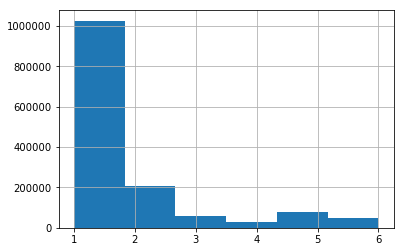

In [15]:
nyc_travel = nyc_travel[
    np.logical_not(
        np.logical_or(
            nyc_travel['passenger_count'] <= 0,
            nyc_travel['passenger_count'] > 6
        )
    )
]

nyc_travel['passenger_count'].hist(bins=6)
plt.show()

## Longitude and latitude

Same approach for the latitude and the longitude values, we should seek for outliers and removed them.

Let's draw a scatter plots using *latitude* and *longitude* as X and Y axis for each location:
- pickup
- dropoff

On this scatter plot, I'll draw a rectangle that will surround the data points that I consider as good data points. The one outside the rectangle will be considered as outliers.

> Note: I'm defining here a function to draw the scatter plots as I will reuse it several time


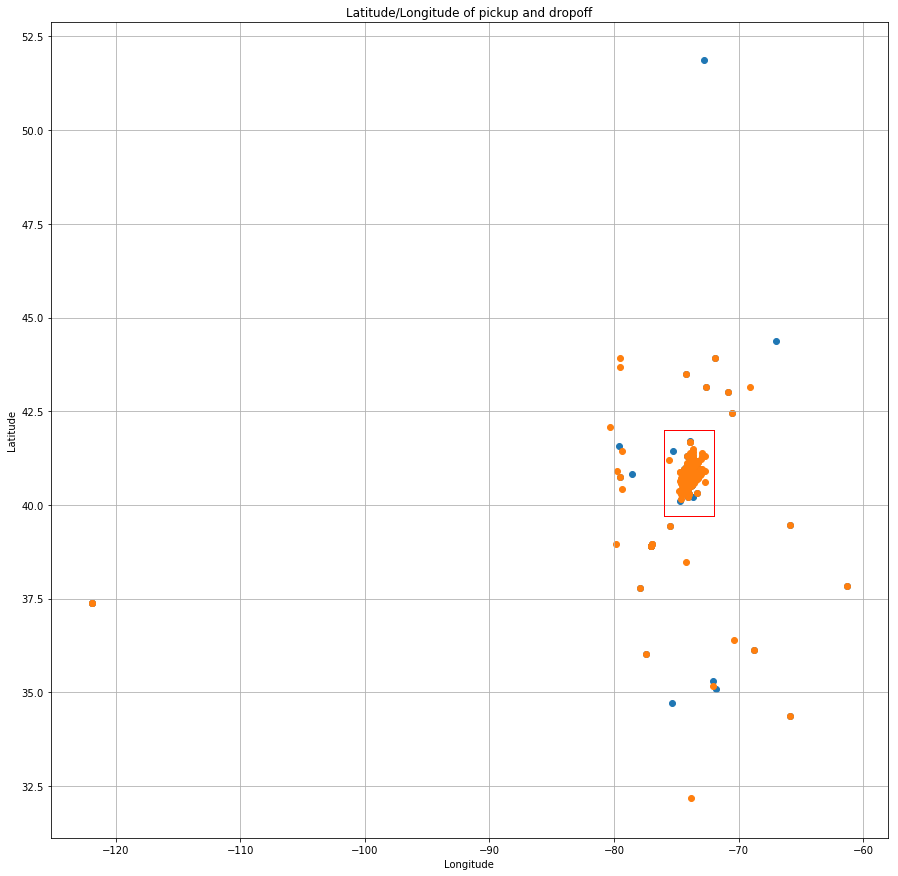

In [16]:
# Set rectangle angle position
LOWER_LEFT=[-72, 39.7]
UPPER_RIGHT=[-76, 42]

def draw_scatter():
    # Set figure size
    plt.figure(figsize=(15, 15))

    # Set axis labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Scatter plot of pickup and dropoff positions
    plt.scatter(nyc_travel['pickup_longitude'], nyc_travel['pickup_latitude'])
    plt.scatter(nyc_travel['dropoff_longitude'], nyc_travel['dropoff_latitude'])

    # Draw rectangle with function from 'my_utils' library
    plot_rectangle(lower_left=LOWER_LEFT, upper_right=UPPER_RIGHT)

    # Display grid axis
    plt.grid()

    # set title
    plt.title("Latitude/Longitude of pickup and dropoff")

    # Show canvas
    plt.show()

draw_scatter()

The rectangle seems to be good and exclude outliers. Let's build a filter based on the rectangle value, count line that will be removed, and draw a new graph with outliers dropped from the dataset.

> Note: The global filter building process is defined as a function to be reused below in this Notebook

Number of lines that will be removed from dataset: 34


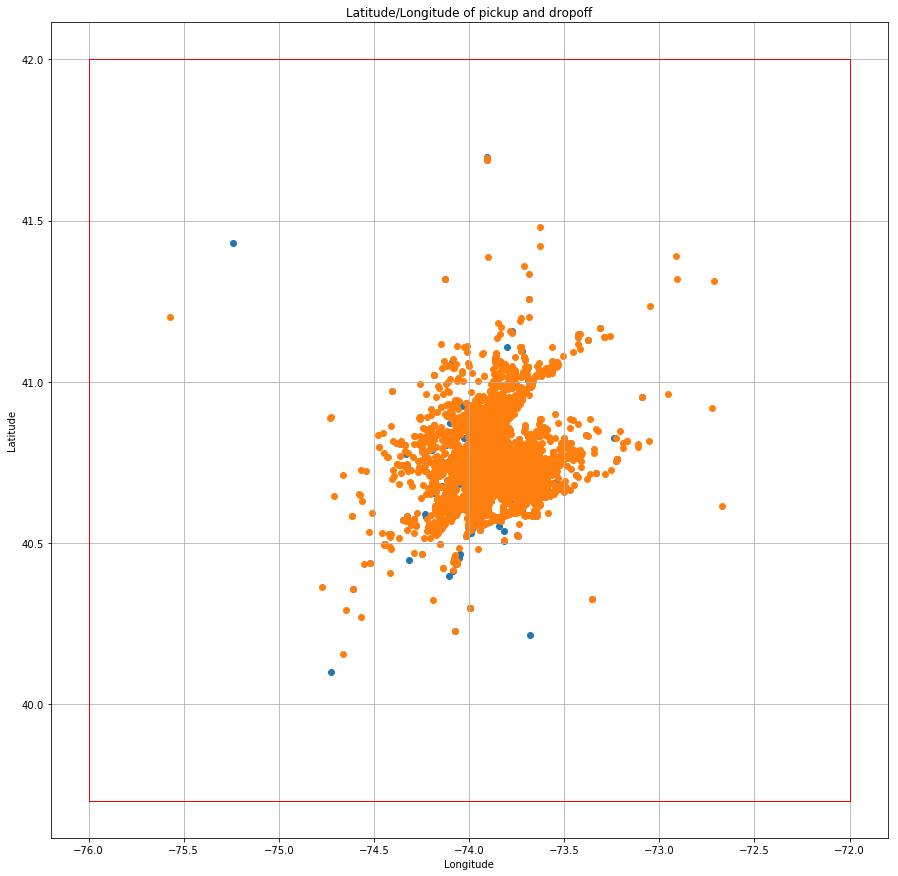

In [17]:
def get_global_filter() -> pd.core.series.Series:
    # Build filter to remove outliers from dataset
    # !! Warning, longitude is a negative value

    # pickup latitude
    pickup_lat_filter=np.logical_and(
        nyc_travel['pickup_latitude'] >= LOWER_LEFT[1],
        nyc_travel['pickup_latitude'] <= UPPER_RIGHT[1]
    )

    # pickup longitude
    pickup_long_filter=np.logical_and(
        nyc_travel['pickup_longitude'] <= LOWER_LEFT[0],  
        nyc_travel['pickup_longitude'] >= UPPER_RIGHT[0]
    )

    # dropoff latitude
    dropoff_lat_filter=np.logical_and(
        nyc_travel['dropoff_latitude'] >= LOWER_LEFT[1],
        nyc_travel['dropoff_latitude'] <= UPPER_RIGHT[1]
    )

    # pickup longitude
    dropoff_long_filter=np.logical_and(
        nyc_travel['dropoff_longitude'] <= LOWER_LEFT[0],
        nyc_travel['dropoff_longitude'] >= UPPER_RIGHT[0]
    )


    # Return global filter
    return np.logical_and(
        np.logical_and(pickup_lat_filter, pickup_long_filter),
        np.logical_and(dropoff_lat_filter, dropoff_long_filter)
    )

# get global filter
global_filter=get_global_filter()

# The try/except block is used when no False values exists in global_filter
try:
    print("Number of lines that will be removed from dataset:", global_filter.value_counts()[False])
except:
    print("No lines found to be removed")


# Remove outliers
nyc_travel=nyc_travel[global_filter]

draw_scatter()


Fine, this datasets finally looks better, but now that I have a clearer view on it due to the first removal of outliers, I think I can do better be redifining the rectangle with closer values.

But, wich values should I use ?

Well, answer can come from the [The 83 Weather Stations](11.The%2083%20Weather%20Stations.ipynb) notebook, where I've plotted the weather stations on the NYC map.

Using a simple query, we can get the limits of the weather stations:

In [18]:
# Get max/min of longitude/latitude from stations dataset
query="SELECT min(LONGITUDE) as min_long, max (LONGITUDE) as max_long, min(latitude) as min_lat, max(latitude) as max_lat from stations"
stations_limit=load_sql(query=query)
stations_limit

Query: SELECT min(LONGITUDE) as min_long, max (LONGITUDE) as max_long, min(latitude) as min_lat, max(latitude) as max_lat from stations


,min_long,max_long,min_lat,max_lat
0,-74.482746,-73.37309,40.275368,41.083546


Use those *stations* limit values to remap our rectangle to a value that will match our weather stations locations:

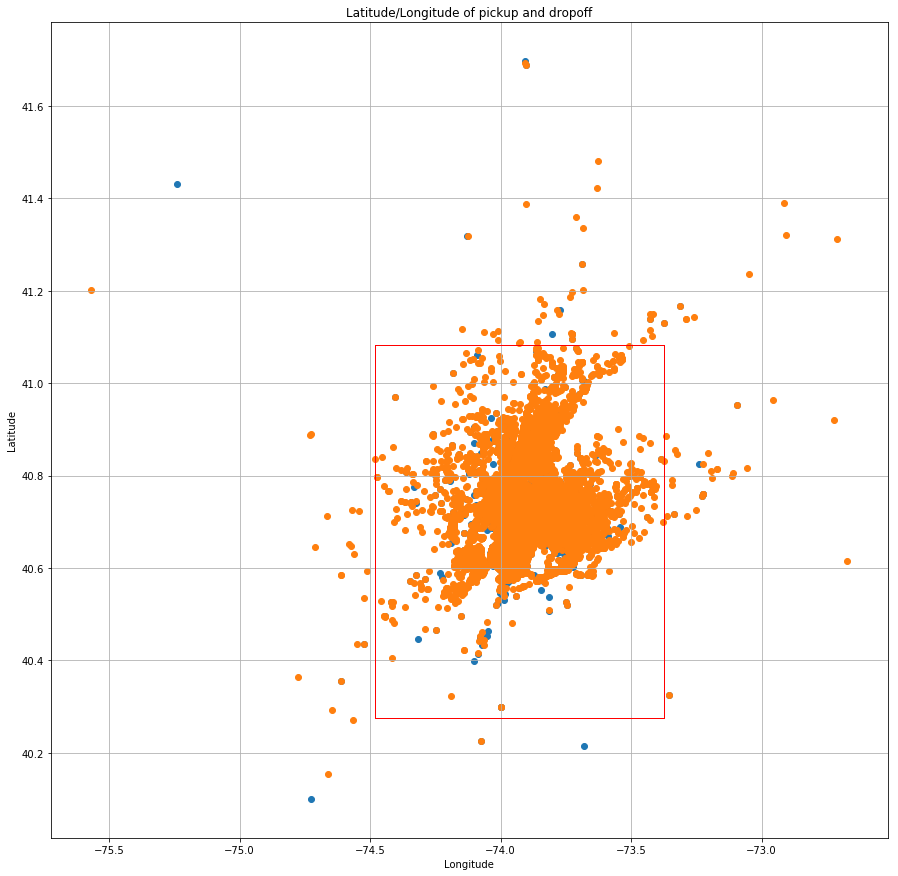

In [19]:
# Set rectangle angle position
LOWER_LEFT=[float(stations_limit['max_long']), float(stations_limit['min_lat'])]
UPPER_RIGHT=[float(stations_limit['min_long']), float(stations_limit['max_lat'])]

draw_scatter()

This new rectangle value will remove a few lines, I think that our outliers removal is quite good now.

Number of lines that will be removed from dataset: 100


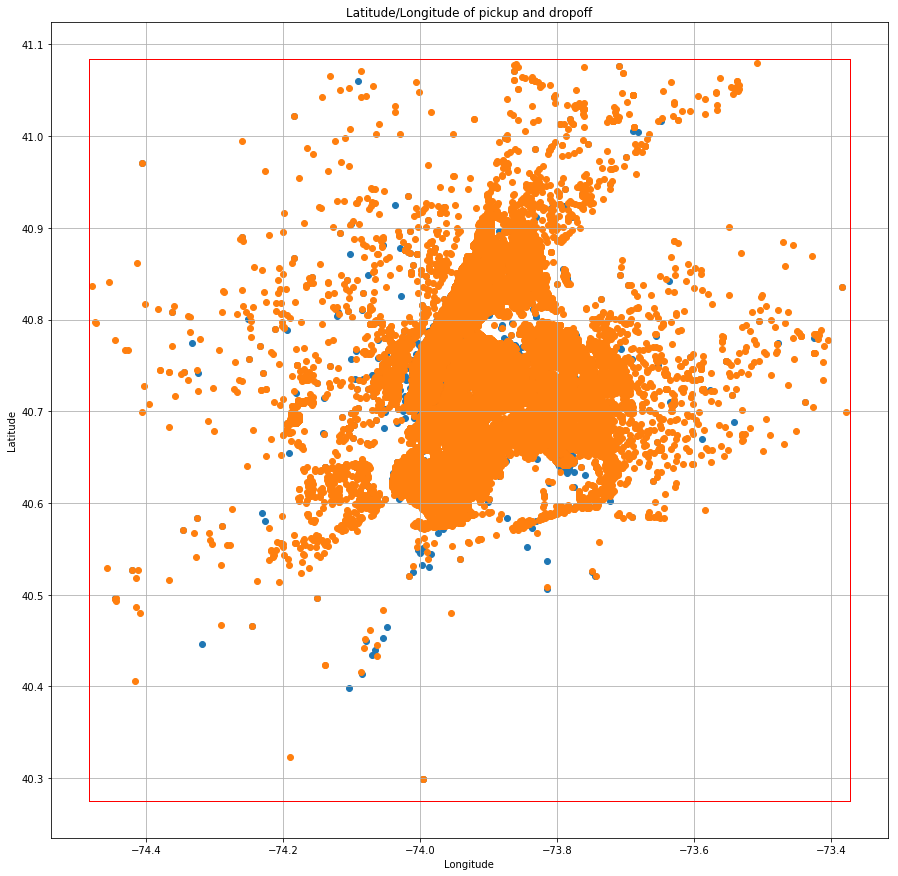

In [20]:
# get global filter
global_filter=get_global_filter()

# The try/except block is used when no False values exists in global_filter
try:
    print("Number of lines that will be removed from dataset:", global_filter.value_counts()[False])
except:
    print("No lines found to be removed")


# Remove outliers
nyc_travel=nyc_travel[global_filter]

draw_scatter()

Hey, that really starts looking like New-York City :-)

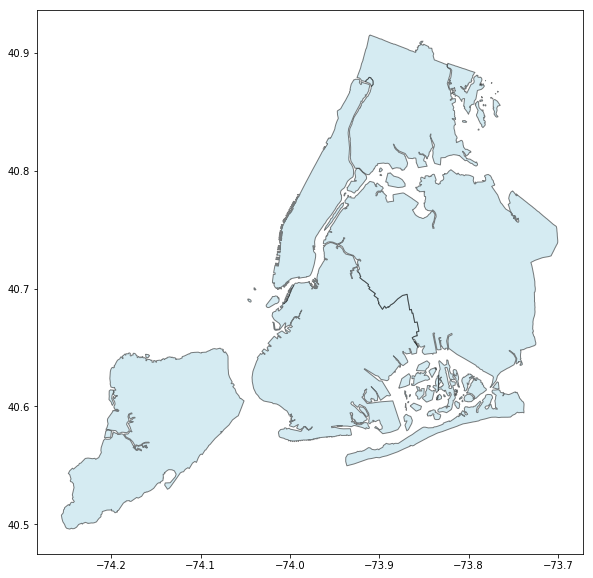

In [21]:
# Function from 'my_utils' library
draw_nyc_map()


As a final control, let's display histogram of the numerical features of this dataset, this will shows how the cleaning process has provided good results.

Number of lines in the dataset: 1447643


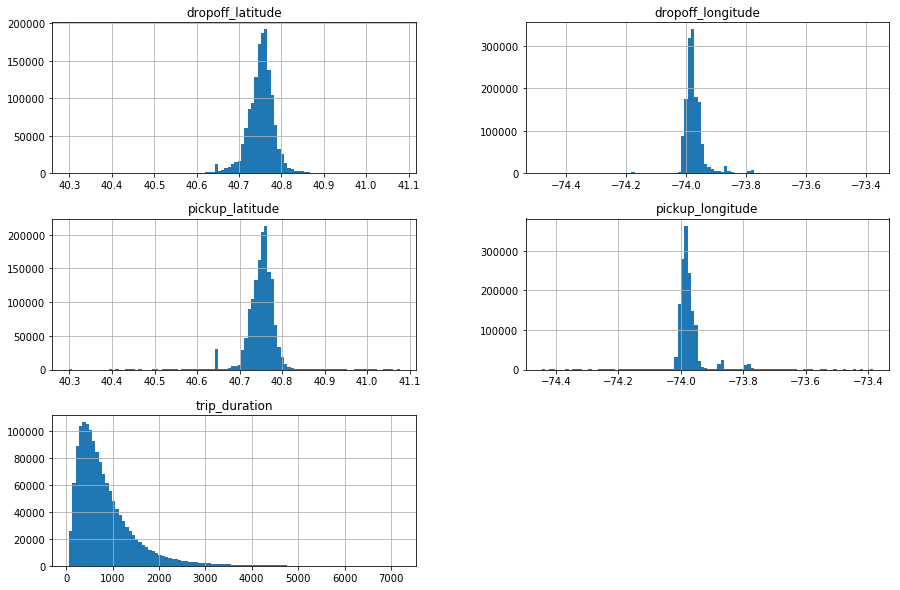

In [22]:

print("Number of lines in the dataset:", nyc_travel['trip_duration'].count())

nyc_travel.drop(['passenger_count', 'store_and_fwd_flag'], axis=1).hist(bins=100, figsize=(15,10))
plt.show()

That'all folks for this Notebook. 

> Note: As we can see on the histogram above, there's some Feature Engineering to do on the dataset, but that's another story.


# Save dataset to SQL database

In [23]:
save_sql(nyc_travel, 'travel')

Saving OK


True

Control that the INSERT process into database worked by counting the number of lines present in the *travel* table:

In [24]:
load_sql(query="SELECT count(*) FROM travel")

Query: SELECT count(*) FROM travel


,count(*)
0,1447643


Let's continue on the next notebook: [NYC Weather Data Preparation](13.NYC%20Weather%20Data%20Preparation.ipynb) :-)